In [1]:
# dev mode
import sys
from typing import List, Tuple, Dict
import matplotlib.pyplot as plt
import networkx as nx
import time
import copy

# interactively load the module
%load_ext autoreload
%autoreload 2

In [2]:
from src.file_reader import BinaryPolygonFileReader, test_load_module
from src.utils_opt import plot_two_polys, plot_two_polys_with_tree, plot_ani
from src.poly_matching_trees_ilp import solve_ilp_trees, Solution
import shapely.plotting
import networkx as nx

'''
    Name,            number of sets
    data_auerberg,              796
    data_dottendorf,            871
    data_duisdorf,             2127
    data_endenich,             1060
    data_zentrum,               160
'''
file_path = "data/data_auerberg"
reader = BinaryPolygonFileReader(file_path)

In [3]:
set_id, polys1, polys2 = reader.read_next_set()
print("set_id: ", set_id)
print("Length polys1: ", len(polys1))
print("Length polys2: ", len(polys2))

set_id:  0
Length polys1:  2
Length polys2:  28


# 1. Algorithm 1
Psuedo-code

<img src="img/algorithm1.jpg" alt="algorithm1" style="width: 700px;"/>

In [4]:
def unpack_poly(polys: List, poly_left_list: List[shapely.Polygon]) -> shapely.Polygon:
    poly_left = None
    for i in poly_left_list:
        if poly_left == None:
            poly_left = polys[i]
        else:
            poly_left = poly_left | polys[i]

    return poly_left

def compare(polys: List, polys_kv: Dict[int, List[shapely.Polygon]], intersect=True) -> Dict[int, List[shapely.Polygon]]:

    smallest_dist = float('inf')
    found_key_i = None
    found_key_j = None
    success = False
    
    for i, poly_left_list in polys_kv.items():
        for j, poly_right_list in polys_kv.items():
            # check sorted
            if i < j:
                # can optimize but left for checking.
                poly_left  = unpack_poly(polys, poly_left_list['referenced_polys'])
                poly_right = unpack_poly(polys, poly_right_list['referenced_polys'])

                if intersect == True:
                    if poly_left.intersects(poly_right):
                        dist_centroid = poly_left.centroid.distance(poly_right.centroid)
                        if dist_centroid < smallest_dist:
                            smallest_dist = dist_centroid
                            found_key_i = i
                            found_key_j = j
                            # print("i, j, dist_centroid", i, j, dist_centroid)
                            merged_i_j = poly_left | poly_right
                else:
                    dist_centroid = poly_left.centroid.distance(poly_right.centroid)
                    if dist_centroid < smallest_dist:
                        smallest_dist = dist_centroid
                        found_key_i = i
                        found_key_j = j
                        merged_i_j = poly_left | poly_right

    if found_key_i == None or found_key_j == None:
        return polys_kv, success
    else:
        polys_kv[j+1] = {}
        polys_kv[j+1]['child_left_node'] = found_key_i
        polys_kv[j+1]['child_right_node'] = found_key_j
        polys_kv[j+1]['referenced_polys'] = polys_kv[found_key_i]['referenced_polys'] + polys_kv[found_key_j]['referenced_polys']
        # print("ref", polys_kv[j+1]['referenced_polys'])
        polys_kv.pop(found_key_i)
        polys_kv.pop(found_key_j)
        success = True
    
    return polys_kv, success


def find_smallest_dist_pairs_polys(polys: List, polys_kv: Dict[int, List[shapely.Polygon]])-> Dict[int, List[shapely.Polygon]]:

    success = None

    if len(polys_kv) < 2:
        return polys_kv

    polys_kv, success = compare(polys, polys_kv)
    if success == False:
        polys_kv, success = compare(polys, polys_kv, intersect=False)

    return polys_kv

In [5]:
def algorithm_1(polys: List)-> nx.classes.graph.Graph:
    G = nx.DiGraph()
    polys_kv = {}

    current_vertex_id = 0
    
    if (len(polys) == 0):
        return G

    for i in range(len(polys)):
        polys_kv[i] = {}
        polys_kv[i]['referenced_polys'] = [i]
        polys_kv[i]['child_left_node'] = {}
        polys_kv[i]['child_right_node'] = {}
        G.add_node(i, vertex_id_in_g=i, referenced_polys=polys_kv[i]['referenced_polys'])
        current_vertex_id = current_vertex_id + 1
        
        # polys_kv[i] = {}
        # polys_kv[i]['referenced_polys'] = [i]
        # polys_kv[i]['child_left_node'] = i
        # polys_kv[i]['child_right_node'] = i
        # G.add_node(i, vertex_id_in_g=i, referenced_polys=[i])
        # G.add_edge(polys_kv[i]['child_left_node'], i)
        # G.add_edge(polys_kv[i]['child_right_node'], i)
        # current_vertex_id = current_vertex_id + 1

    while (len(polys_kv) > 1):
        polys_kv = find_smallest_dist_pairs_polys(polys, polys_kv)

        G.add_node(current_vertex_id, vertex_id_in_g=current_vertex_id, referenced_polys=polys_kv[current_vertex_id]['referenced_polys'])
        G.add_edge(polys_kv[current_vertex_id]['child_left_node'], current_vertex_id)
        G.add_edge(polys_kv[current_vertex_id]['child_right_node'], current_vertex_id)
        current_vertex_id = current_vertex_id + 1

    return G

In [6]:
set_id, polys1, polys2 = reader[418] 
print("set_id: ", set_id)
print("Length polys1: ", len(polys1))
print("Length polys2: ", len(polys2))


# Optimize error 
# 105, 136, 144, 167, 183, 215, 218, 268, 275, 296, 330, 356, 365, 376, 
# 383, 396, 399, 415, 418, 420, 434, 438, 465, 466, 471, 473, 492, 505, 
# 518, 519, 554, 573, 575, 580, 589, 598, 605, 610, 623, 629, 639, 647, 
# 678, 679, 697, 699, 708, 712, 721, 726, 728, 732, 736, 737, 745, 746, 
# 750, 757, 763, 776, 778, 780, 783, 785

set_id:  418
Length polys1:  3
Length polys2:  2


## 1.2 Plot

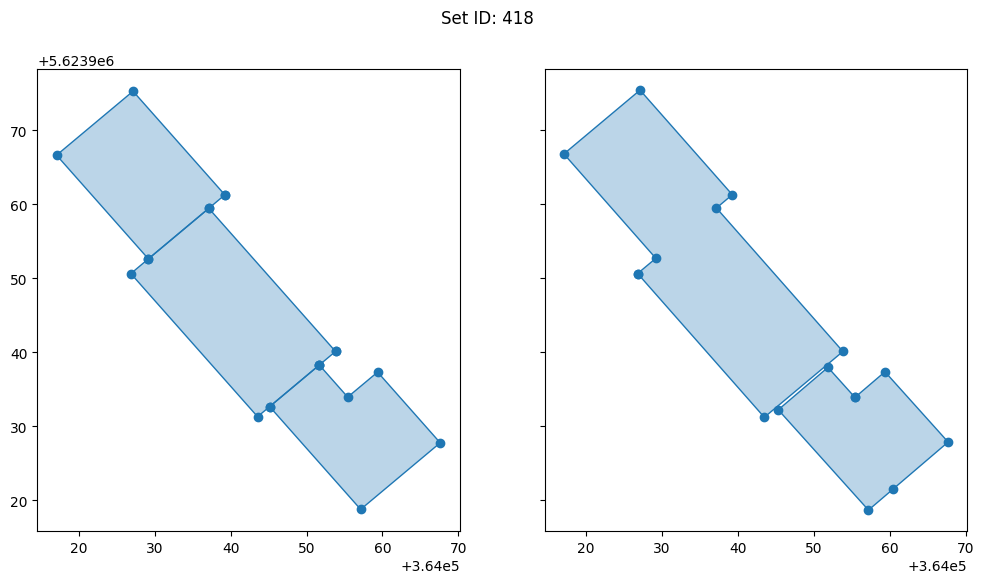

In [7]:
plot_two_polys(polys1, polys2, set_id)

## 1.3 Plot with nodes

In [8]:
G1 = algorithm_1(polys1)
G2 = algorithm_1(polys2)

In [9]:
G1.edges.data()

OutEdgeDataView([(0, 3, {}), (1, 3, {}), (2, 4, {}), (3, 4, {})])

In [10]:
G2.edges.data()

OutEdgeDataView([(0, 2, {}), (1, 2, {})])

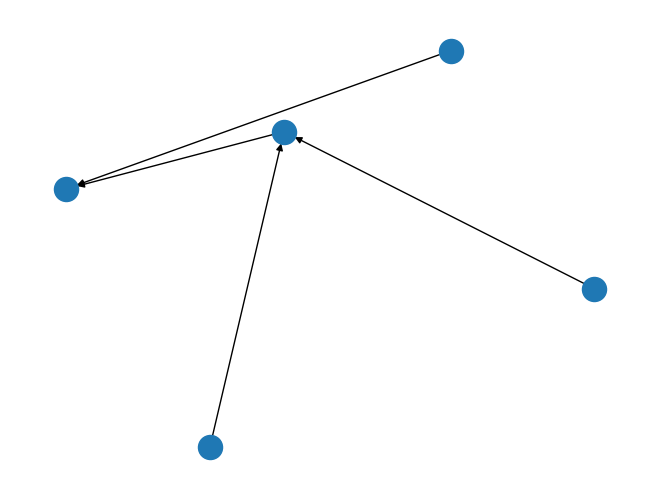

In [11]:
nx.draw(G1)

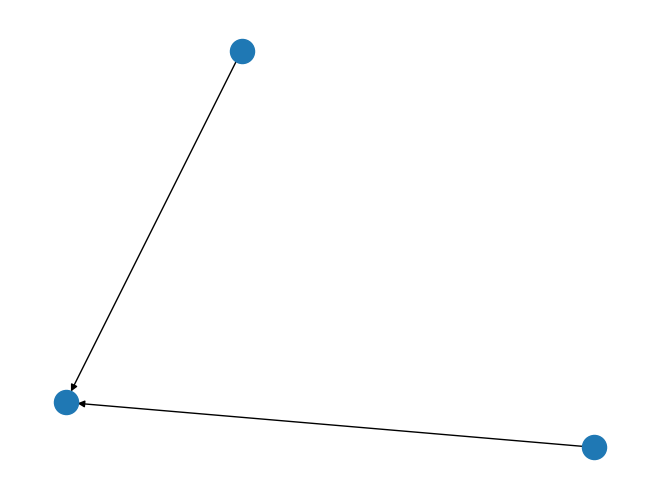

In [12]:
nx.draw(G2)

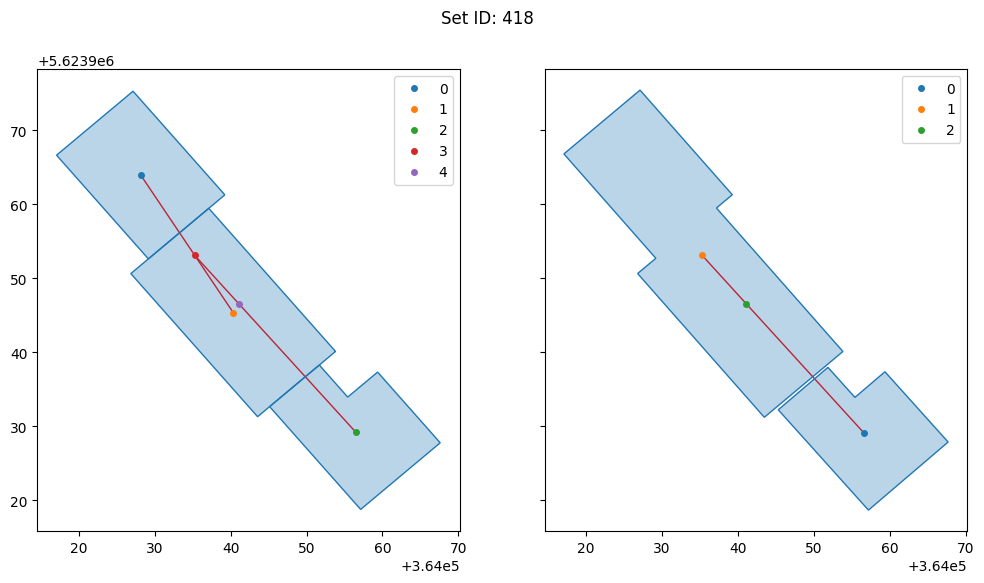

In [13]:
plot_two_polys_with_tree(polys1, polys2, G1, G2, set_id)

In [14]:
# plot_ani(polys1, polys2, G1, G2, set_id)

## 1.3 Run on the whole datasets

In [15]:
# '''
#     Name,            number of sets
#     data_auerberg,              796
#     data_dottendorf,            871
#     data_duisdorf,             2127
#     data_endenich,             1060
#     data_zentrum,               160
# '''
# file_path = "data/data_auerberg"
# # file_path = "data/data_dottendorf"
# # file_path = "data/data_duisdorf"
# # file_path = "data/data_endenich"
# # file_path = "data/data_zentrum"
# reader = BinaryPolygonFileReader(file_path)

# 2. Comparison

In [42]:
set_id, polys1, polys2 = reader[623] 
print("set_id: ", set_id)
print("Length polys1: ", len(polys1))
print("Length polys2: ", len(polys2))


# Optimize error 
# 105, 136, 144, 167, 183, 215, 218, 268, 275, 296, 330, 356, 365, 376, 
# 383, 396, 399, 415, 418, 420, 434, 438, 465, 466, 471, 473, 492, 505, 
# 518, 519, 554, 573, 575, 580, 589, 598, 605, 610, 623, 629, 639, 647, 
# 678, 679, 697, 699, 708, 712, 721, 726, 728, 732, 736, 737, 745, 746, 
# 750, 757, 763, 776, 778, 780, 783, 785


# G1 > G2 : G2 == 1
# 699, 721, 726

set_id:  623
Length polys1:  24
Length polys2:  25


In [43]:
G1 = algorithm_1(polys1)
G2 = algorithm_1(polys2)

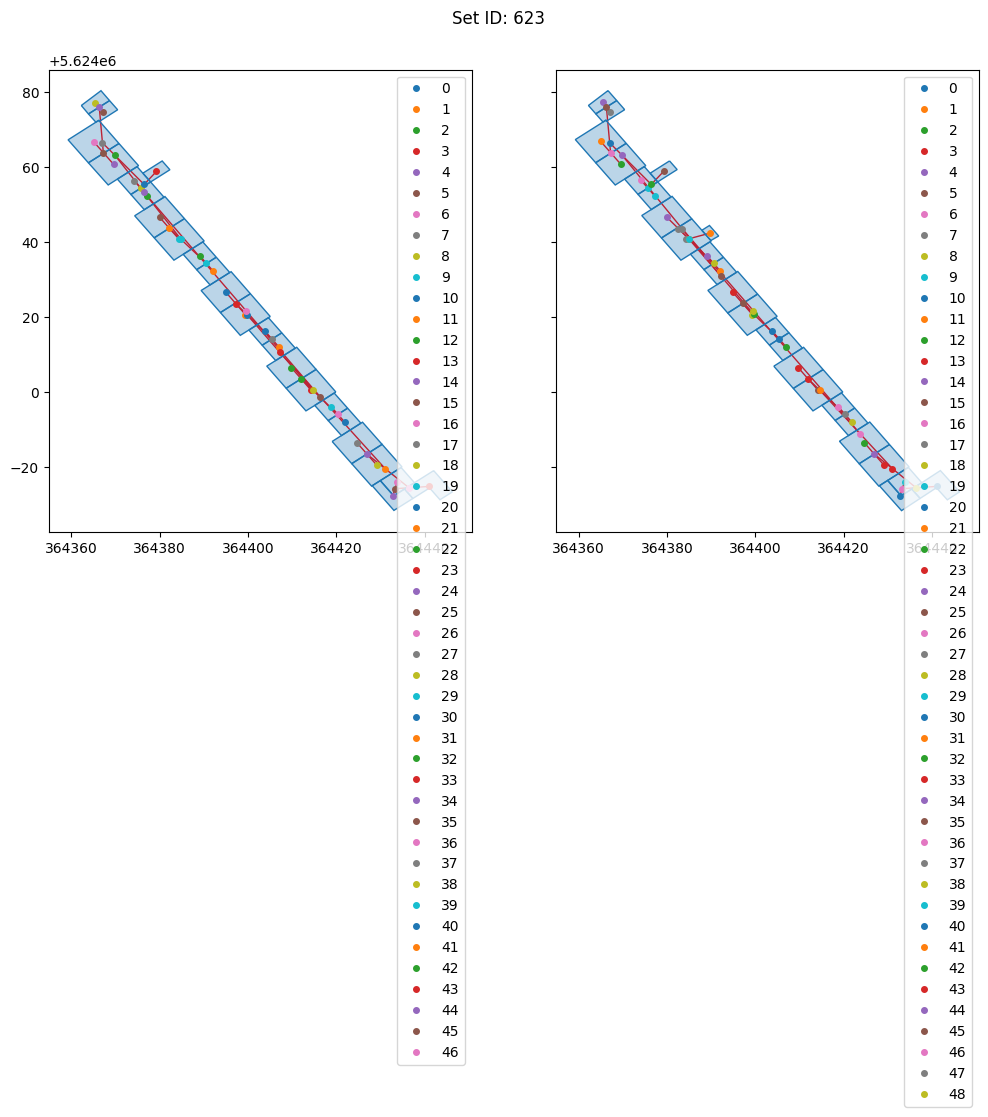

In [44]:
plot_two_polys_with_tree(polys1, polys2, G1, G2, set_id)

In [45]:
from networkx.algorithms import bipartite
B_sol = nx.Graph()
sol_algo1 = Solution()

In [41]:
# Build Bipartite
lamda = 0.8
iou_max = float('-inf')

for G1_node_num in range(len(G1)):
    for G2_node_num in range(len(G2)):
        
        B_sol.add_nodes_from([ (G1_node_num, {
            'referenced_map': True, 
            'referenced_polys': G1.nodes[G1_node_num]['referenced_polys']                     
        })  ], bipartite=0)
        B_sol.add_nodes_from([ (G2_node_num, {
            'referenced_map': False, 
            'referenced_polys': G2.nodes[G2_node_num]['referenced_polys']
        })  ], bipartite=1)

        polygon1 = unpack_poly(polys1, G1.nodes[G1_node_num]['referenced_polys'])
        polygon2 = unpack_poly(polys2, G2.nodes[G2_node_num]['referenced_polys'])
        
        intersect = polygon1.intersection(polygon2).area
        union = polygon1.union(polygon2).area
        iou = intersect / union
        if iou > iou_max:
            iou_max = iou
        
        B_sol.add_edges_from([ (G1_node_num, G2_node_num, {'weight': iou - lamda}) ]             )
solve_ilp_trees(g=B_sol, tree_osm=G1, tree_atkis=G2, num_osm_polys=len(polys1), num_atkis_polys=len(polys2), solution=sol_algo1)

    
print("iou_max", iou_max)
print("sol_algo1.objective", sol_algo1.objective)

Set parameter Threads to value 1
Set parameter LogToConsole to value 0
iou_max 0.9801226813206129
sol_algo1.objective 0.042159125753266635
